##  Congratulations, you are now hired as a sport analytic. Your job is to give prediciton for the next Mathball tournament of the Six finest mathematicians in the world, which is a competition between Laplace, Gauss, Newton, Euler, Leibniz, Von-Neumann.

## The mathball is just like football where a player a goal is legal only after scoring you answer correctly a math question.

## Motivation:  
### We want to infer a latent parameter - that is the 'strength' of a mathematician based only on their **scoring intensity**, and all we have are their scores and results, we can't accurately measure the 'strength' of a team.


In [1]:
# imports
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import pickle as pkl

## The input   looks like as follows:

In [2]:
group = 24
df_all  = pkl.load(open('../content/data_mathball/mathball_data_group_' + str(group)+ '.pkl', 'rb'))
df_all.head()

,home_player,away_player,home_score,away_score,year
0,Laplace,Von-Neumann,27,24,1897
1,Gauss,Euler,26,3,1897
2,Newton,Laplace,17,19,1897
3,Euler,Leibniz,23,15,1897
4,Laplace,Leibniz,31,10,1897


## We have home and away team, we have score and year.

## What do we want to infer?

### We want to infer the latent parameters (every mathematian's strength) that are generating the data we observe (the scorelines).
### Moreover, we know that the scorelines are a noisy measurement of team strength, so ideally, we want a model that makes it easy to quantify our uncertainty about the underlying strengths.

## What do we want?

### We want to quantify our uncertainty
### We want to also use this to generate a model
### We want the answers as distributions not point estimates

## Part 1

### We next do some exploratory data analysis. The idea is to get a general sense of what is going on.

## Tasks

### 1. Plot a bar chart of the goal difference (i.e., total scored minus total scored against) per mathematician. Who is the best mathematician and who is the worst according to this plot?
### 2. Plot the same bar chart for each mathematician  as a function of time. Do you see a monote behvaoir which implies an improvement or the other way around for one of mathematician?
### 3. Choose your favorite mathematician, compare the goal difference between home and away games. Is he better in home or away games? Plot a bar chart of the goal difference for both home and away games.
### 4. Which mathematician has the best median away results? (that is, for each mathematician go over all of his away games, compute his scoring difference (how much he scored minues got scored against) and compute the median value).

### **Answers to part 1:**

**1:**

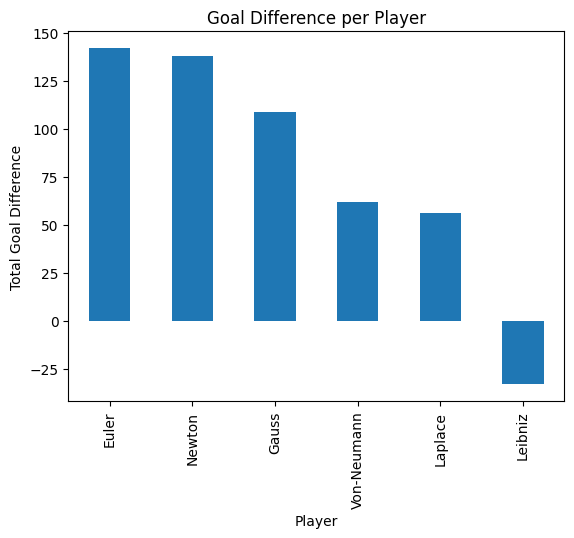

The best mathematician is Euler with a goal difference of 142.
The worst mathematician is Leibniz with a goal difference of -33.


In [3]:
# Calculate goal difference for home and away players
df_all['home_goal_diff'] = df_all['home_score'] - df_all['away_score']
df_all['away_goal_diff'] = df_all['away_score'] - df_all['home_score']

# Aggregate goal differences for each player
home_goal_diff = df_all.groupby('home_player')['home_goal_diff'].sum().reset_index()
away_goal_diff = df_all.groupby('away_player')['away_goal_diff'].sum().reset_index()

# Merge the home and away goal differences
goal_diff = pd.merge(home_goal_diff, away_goal_diff, left_on='home_player', right_on='away_player', how='outer')
goal_diff = goal_diff.fillna(0)

# Calculate the total goal difference
goal_diff['total_goal_diff'] = goal_diff['home_goal_diff'] - goal_diff['away_goal_diff']

# Rename the player column and set it as index
goal_diff['player'] = goal_diff['home_player'].combine_first(goal_diff['away_player'])
goal_diff = goal_diff[['player', 'total_goal_diff']].set_index('player')

# Plotting the bar chart
goal_diff.sort_values(by='total_goal_diff', ascending=False, inplace=True)
goal_diff.plot(kind='bar', legend=False)
plt.title('Goal Difference per Player')
plt.xlabel('Player')
plt.ylabel('Total Goal Difference')
plt.show()

# Determine the best and worst player
best_player = goal_diff['total_goal_diff'].idxmax()
worst_player = goal_diff['total_goal_diff'].idxmin()

print(f"The best mathematician is {best_player} with a goal difference of {goal_diff['total_goal_diff'].max()}.")
print(f"The worst mathematician is {worst_player} with a goal difference of {goal_diff['total_goal_diff'].min()}.")

**2:**

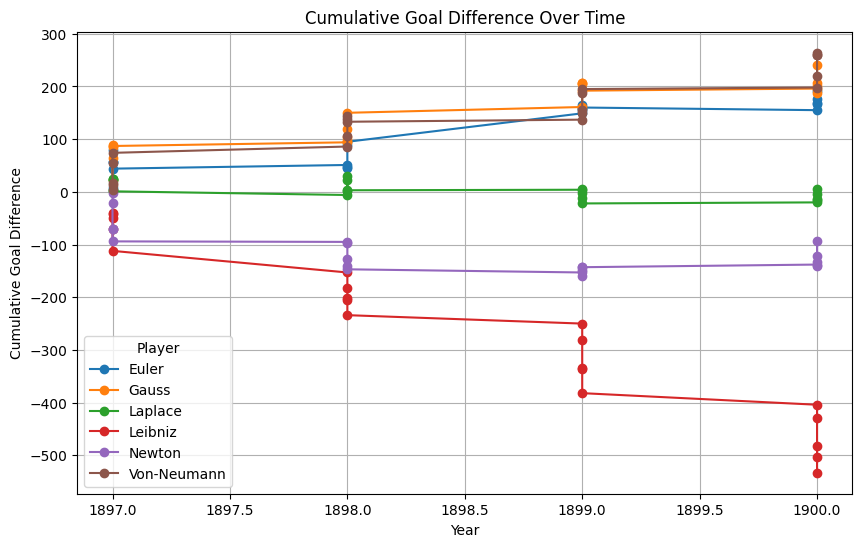

In [4]:
# Calculate goal difference for home and away players
df_all['home_goal_diff'] = df_all['home_score'] - df_all['away_score']
df_all['away_goal_diff'] = df_all['away_score'] - df_all['home_score']

# Melt the DataFrame to long format
df_home = df_all[['year', 'home_player', 'home_goal_diff']].rename(columns={'home_player': 'player', 'home_goal_diff': 'goal_diff'})
df_away = df_all[['year', 'away_player', 'away_goal_diff']].rename(columns={'away_player': 'player', 'away_goal_diff': 'goal_diff'})
df_long = pd.concat([df_home, df_away])

# Sort by player and year for cumulative sum calculation
df_long = df_long.sort_values(by=['player', 'year'])

# Calculate cumulative goal difference
df_long['cumulative_goal_diff'] = df_long.groupby('player')['goal_diff'].cumsum()

# Plotting the cumulative goal difference over time for each player
plt.figure(figsize=(10, 6))
for player in df_long['player'].unique():
    player_data = df_long[df_long['player'] == player]
    plt.plot(player_data['year'], player_data['cumulative_goal_diff'], marker='o', label=player)

plt.title('Cumulative Goal Difference Over Time')
plt.xlabel('Year')
plt.ylabel('Cumulative Goal Difference')
plt.legend(title='Player')
plt.grid(True)
plt.show()

According to the graph 'Cumulative Goal Difference Over Time'
The following trends can be seen:
1. Gauss and Von-Neumann show a positive monotonic improvement trend.
2. Leibniz shows a negative monotonic improvement trend.
3. Laplace and Newton show a neutral monotonic improvement trend.
4. Euler shows a positive but non-monotonic conservation trend because a jump can be seen between the years 1898-1899.

**3:**

I gave the right to choose in this section to my mother (Yael's) who did a degree in mathematics and she **chose Euler** because he contributed in many fields, and was amazingly creative (p.s. according to her everyone on the list is like that and Newton is a super genius).

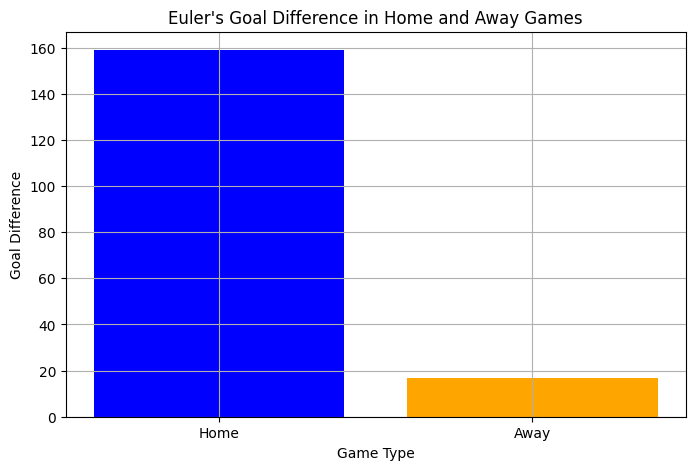

Euler is better in home games.


In [5]:
# Calculate goal difference for home and away players
df_all['home_goal_diff'] = df_all['home_score'] - df_all['away_score']
df_all['away_goal_diff'] = df_all['away_score'] - df_all['home_score']

# Filter data for Euler
euler_home = df_all[df_all['home_player'] == 'Euler']
euler_away = df_all[df_all['away_player'] == 'Euler']

# Calculate total goal difference for home and away games
euler_home_goal_diff = euler_home['home_goal_diff'].sum()
euler_away_goal_diff = euler_away['away_goal_diff'].sum()

# Create a DataFrame for plotting
euler_goal_diff = pd.DataFrame({
    'Game Type': ['Home', 'Away'],
    'Goal Difference': [euler_home_goal_diff, euler_away_goal_diff]
})

# Plotting the bar chart
plt.figure(figsize=(8, 5))
plt.bar(euler_goal_diff['Game Type'], euler_goal_diff['Goal Difference'], color=['blue', 'orange'])
plt.title("Euler's Goal Difference in Home and Away Games")
plt.xlabel('Game Type')
plt.ylabel('Goal Difference')
plt.grid(True)
plt.show()

# Determine if Euler is better in home or away games
if euler_home_goal_diff > euler_away_goal_diff:
    result = "Euler is better in home games."
elif euler_home_goal_diff < euler_away_goal_diff:
    result = "Euler is better in away games."
else:
    result = "Euler performs equally in home and away games."

print(result)

**4:**

In [6]:
# Calculate goal difference for away players
df_all['away_goal_diff'] = df_all['away_score'] - df_all['home_score']

# Group by away player and calculate the median goal difference
away_goal_diff_median = df_all.groupby('away_player')['away_goal_diff'].median().reset_index()

# Determine the mathematician with the best median away results
best_away_player = away_goal_diff_median.loc[away_goal_diff_median['away_goal_diff'].idxmax()]

print(f"The mathematician with the best median away results is {best_away_player['away_player']} with a median goal difference of {best_away_player['away_goal_diff']}.")

The mathematician with the best median away results is Von-Neumann with a median goal difference of 5.5.


## Part 2

## What assumptions do we know for our mathball competition?

### We know that there are 6 mathematicians, each year all possible pairs playes once.  
### We have data from the last few years
### We also know that in sports scoring is modelled as a Poisson distribution (even in mathball)
### We consider home advantage to be a strong effect in sports

## The model.

### The league is made up by a total of T= 6 mathematicians, playing each other once in a season.

### We indicate the number of goals scored by the home and the away player in the g-th game of the season (15 games) as $y_{g1}$ and $y_{g2}$ respectively. </p>
### The vector of observed goal counts $\mathbb{y} = (y_{g1}, y_{g2})$ is modelled as independent Poisson:
## $$y_{gj}| \theta_{gj} \tilde\;\;  Poisson(\theta_{gj})$$
### where the theta parameters represent the scoring intensity in the g-th game for the team playing at home (j=1) and away (j=2), respectively.</p>

## We model these parameters according to a formulation that has been used widely in the statistical literature, assuming a log-linear random effect model:
### $$ log \theta_{g1} = intercept + home + \hat{att}_{h(g)} + \hat{def}_{a(g)} $$
### $$ log \theta_{g2} = intercept + \hat{att}_{a(g)} + \hat{def}_{h(g)}$$


## Alternitevly:

### $$  \theta_{g1} = e^{intercept + home + \hat{att}_{h(g)} + \hat{def}_{a(g)}} $$
### $$  \theta_{g2} = e^{intercept + \hat{att}_{a(g)} + \hat{def}_{h(g)}}$$

### $\hat{att}_{h(g)}$ is the attack effect of a player.
### $\hat{def}_{h(g)}$ is the attack effect of a player.

### For mathematician  i = 1, ..., 6, both  $\hat{att}_{i}$ and $\hat{def}_{i}$ are normalized values, fomrally:

### $$ \hat{att}_{i} = att_i - \bar{att} $$
### $$ \hat{def}_{i} = att_i - \bar{def} $$

where,

### $$ \bar{att}  = \frac{\sum_{i=1}^6 att_i}{6} $$
### $$ \bar{def}  = \frac{\sum_{i=1}^6 def_i}{6} $$

### Just for clarification: suppose we index mathematicians as follows:
### 1: Laplace
### 2: Gauss
### 3: Newton
### 4: Euler
### 5: Leibniz
### 6: Von-Neumann

### Now, suppose the first game is Laplace hosting Gauss (the clash of the titans).
### Thus, $h(1) = 1 $ (i.e.,Laplace ) and $a(1) = 2 $ (i.e., Gauss).

### The parameter home represents the advantage for the team hosting the game and we assume that this effect is constant for all the teams and throughout the season
### The scoring intensity is determined jointly by the attack and defense ability of the two teams involved, represented by the parameters att and def, respectively

### Conversely, for each i = 1, ..., 6, the player-specific effects are modelled as exchangeable from a common distribution:

### $att_{i} \; \tilde\;\; Normal(0,\tau_{att})$ and $def_{i} \; \tilde\;\;Normal(0,\tau_{def})$

### The log function to away scores and home scores is a standard trick in the sports analytics literature

## Tasks

### 1. Build a Hierarchical model with PyMc where you obtain a posterior of the latent variables: $home$, $att_i$,  $def_i$ for $i = \{1,2,3,4,5,6\} $ and $intercept$.
### Remark: Set the MCMC configuration regarding the number of draws, such that there will 4000 samples in total.



## guidence:
###  For the Hierarchical model, connect the different players (mathematicians) only via the attack and defence std (i.e., $\tau_{att}$ and $\tau_{def}$) and not the mean value.

## Indexing the data for the pymc model

In [7]:
import numpy as np

In [8]:
group = 24
df_all  = pkl.load(open('../content/data_mathball/mathball_data_group_' + str(group)+ '.pkl', 'rb'))
df_all.head()

,home_player,away_player,home_score,away_score,year
0,Laplace,Von-Neumann,27,24,1897
1,Gauss,Euler,26,3,1897
2,Newton,Laplace,17,19,1897
3,Euler,Leibniz,23,15,1897
4,Laplace,Leibniz,31,10,1897


In [9]:
# ## for your convinience we have here the home and away index with respect to df_all.
# home_idx, teams = pd.factorize(df_all["home_player"], sort=True)
# away_idx, _ = pd.factorize(df_all["away_player"], sort=True)

In [10]:
# df_all.head()

In [11]:
# home_idx

In [12]:
# coords = {"team": teams, 'home_idx': home_idx, 'away_idx': away_idx}

# with pm.Model(coords=coords) as mathball:

#     # Hyperpriors
#     tau_att = # your code here
#     tau_def = # your code here

#     # Priors
#     intercept = #
#     home = #
#     att = pm.Normal('att', mu=0, sigma=tau_att, dims="team")
#     def_ = pm.Normal('def', mu=0, sigma=tau_def, dims="team")

#     ## att_centered function: substracting the mean att using pm.math.mean (your code here)
#     ## att_centered function: substracting the mean def using pm.math.mean (your code here)

#     # Rate models
#     ## rate home function: intercept  + home +  att_centered[home_indx] + def_centered[away_idx] (your code here)
#     ## rate home function: intercept  +  att_centered[away_idx] + def_centered[home_indx] (your code here)

#     theta_g1 = # exponent funciton home games (your code here)
#     theta_g2 = # exponent funciton away games (your code here)

#     # Data likelihood
#     y1_likelihood = # Likelihood home score a function theta_g1 - Poisson (your code here)
#     y2_likelihood = # Likelihood home score  function theta_g2 - Poisson  (your code here) a function thetag2

#     ## pm.sample(your code here)

In [13]:
# teams

In [14]:
# away_idx

In [15]:
# df_all.head(7)

## Your code in here

### **Answers to part 2:**

In [16]:
## for your convinience we have here the home and away index with respect to df_all.
home_idx, teams = pd.factorize(df_all["home_player"], sort=True)
away_idx, _ = pd.factorize(df_all["away_player"], sort=True)

In [17]:
coords = {"team": teams, 'home_idx': home_idx, 'away_idx': away_idx}

with pm.Model(coords=coords) as mathball:

    # Hyperpriors
    tau_att = pm.HalfNormal('tau_att', sigma=1)
    tau_def = pm.HalfNormal('tau_def', sigma=1)

    # Priors
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    home = pm.Normal('home', mu=0, sigma=1)
    att = pm.Normal('att', mu=0, sigma=tau_att, dims="team")
    def_ = pm.Normal('def', mu=0, sigma=tau_def, dims="team")

    ## att_centered function: substracting the mean att using pm.math.mean (your code here)
    att_centered = att - pm.math.mean(att)
    ## att_centered function: substracting the mean def using pm.math.mean (your code here)
    def_centered = def_ - pm.math.mean(def_)

    # theta models
    # log theta_g1 function: intercept  + home +  att_centered[home_indx] + def_centered[away_idx]
    # exponent funciton home games (theta_g1) (your code here)
    theta_g1 = pm.Deterministic('theta_home', pm.math.exp(intercept + home + att_centered[home_idx] + def_centered[away_idx]))
    # log theta_g2 function: intercept  +  att_centered[away_idx] + def_centered[home_indx]
    # exponent funciton away games (theta_g2) (your code here)
    theta_g2 = pm.Deterministic('theta_away', pm.math.exp(intercept + att_centered[away_idx] + def_centered[home_idx]))

    # Data likelihood
    # Likelihood home score a function theta_g1 - Poisson (your code here)
    y1_likelihood = pm.Poisson('y1', mu=theta_g1, observed=df_all['home_score'].values)
    # Likelihood home score  function theta_g2 - Poisson (your code here)
    y2_likelihood = pm.Poisson('y2', mu=theta_g2, observed=df_all['away_score'].values)

    ## pm.sample (your code here)
    trace = pm.sample(2000, tune=1000)

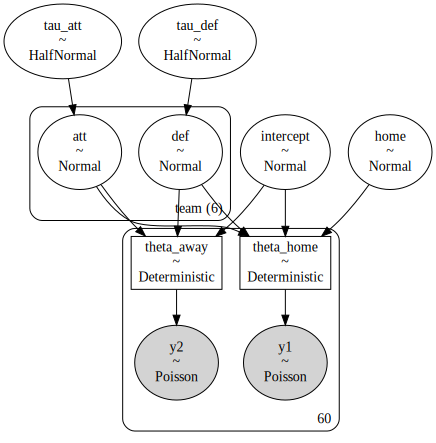

In [18]:
pm.model_to_graphviz(mathball)

## Part 3

## We aim to understand the different distributions of attacking strength and defensive strength.
## These are probabilistic estimates and help us better understand the uncertainty in sports analytics.

## Tasks

### 1. Plot the attack and defence strenght HDI for each team and compare them. Which player has the best offence and which has the best defence? who has the worst offence and defence? Does these results is aligned with part 1 analysis?
### 2. What is the probability that Euler has a better defence than Gauss?
### 3. Suppose Leibniz is hosting Newton for a game. What is the probability that Leibniz will score more than 20? what is the probability that Newton will score less than 20?

### 4. Simulate who wins over a total of 4000 simulations, one per sample in the posterior. Hint: use the sample_posterior_predictive function.
### The resulting simulation should give you the score per each game for all possible combinations for 4 seasons. For each sample out of the 4000 we can measure who will be ranked 1st, 2nd, etc. The ranking is done as follows:
### If a player wins he gets 3 points, draw a single point and lost 0 points. Sum up the points and you will get a full ranking. If we aggregate the results, we can the probability for each player for each position.

### You are required to draw a bar chart that indicates the probability of all possible ranks for each team.


In [20]:
# from IPython.display import Image, display
# image_path = 'img_bar_chat.jpg'
# display(Image(filename=image_path))

## Your code and answers here

### **Answers to part 3:**

**1:**

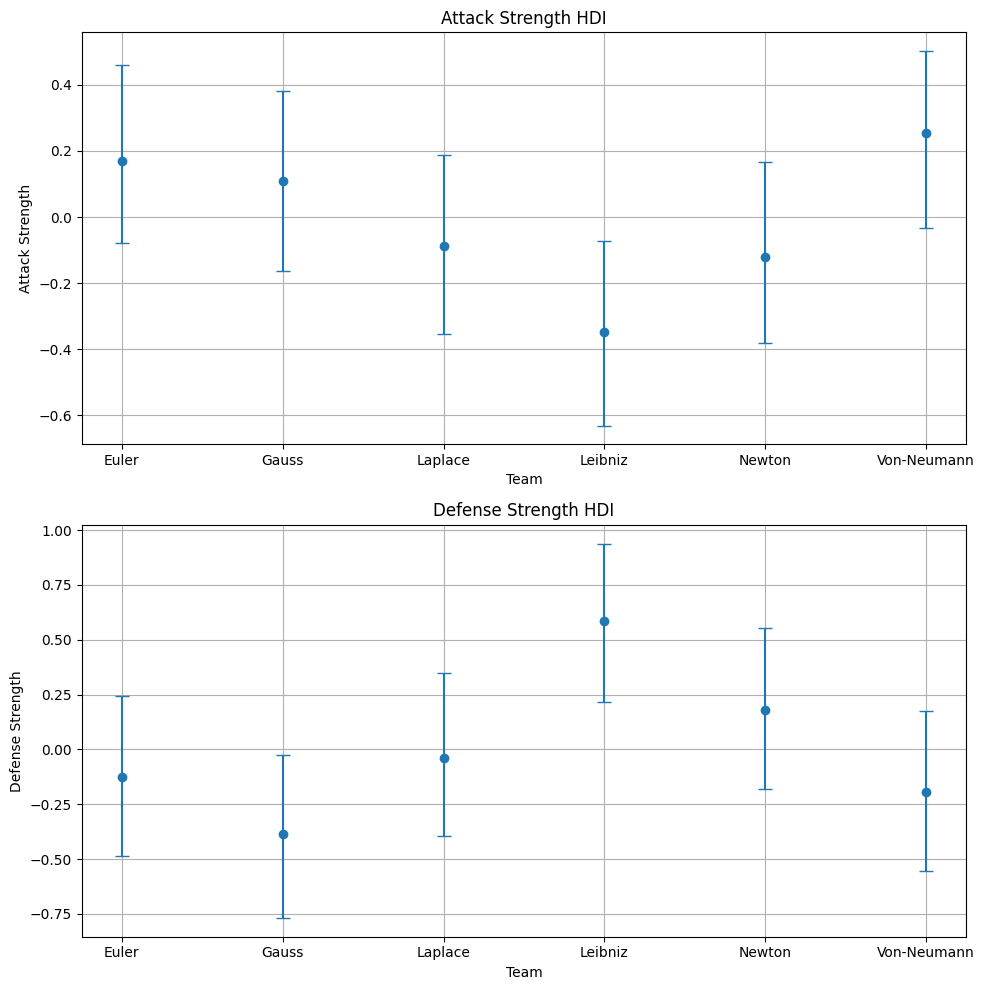

Attack Strength df:
          Team      Mean  HDI Lower  HDI Upper
0        Euler  0.170721  -0.078892   0.460800
1        Gauss  0.107890  -0.163289   0.382368
2      Laplace -0.086513  -0.354747   0.188607
3      Leibniz -0.349314  -0.631163  -0.074107
4       Newton -0.122478  -0.380519   0.166616
5  Von-Neumann  0.253119  -0.032445   0.502357
Defense Strength df:
          Team      Mean  HDI Lower  HDI Upper
0        Euler -0.123864  -0.486332   0.243932
1        Gauss -0.387713  -0.768689  -0.025807
2      Laplace -0.039984  -0.393274   0.348214
3      Leibniz  0.585722   0.214719   0.938342
4       Newton  0.179898  -0.179624   0.552534
5  Von-Neumann -0.194466  -0.552752   0.175136


In [21]:
# Extract the posterior samples
att_samples = trace.posterior['att'].values
def_samples = trace.posterior['def'].values

# Calculate the HDI for attack and defense strengths
hdi_att = az.hdi(att_samples, hdi_prob=0.94)
hdi_def = az.hdi(def_samples, hdi_prob=0.94)

# Prepare data for plotting
team_names = teams
att_mean = att_samples.mean(axis=(0, 1))
def_mean = def_samples.mean(axis=(0, 1))

att_hdi_lower = hdi_att[:, 0]
att_hdi_upper = hdi_att[:, 1]
def_hdi_lower = hdi_def[:, 0]
def_hdi_upper = hdi_def[:, 1]

# Create a DataFrame for easier plotting
data_att = pd.DataFrame({
    'Team': team_names,
    'Mean': att_mean,
    'HDI Lower': att_hdi_lower,
    'HDI Upper': att_hdi_upper
})

data_def = pd.DataFrame({
    'Team': team_names,
    'Mean': def_mean,
    'HDI Lower': def_hdi_lower,
    'HDI Upper': def_hdi_upper
})

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Attack Strength Plot
axes[0].errorbar(data_att['Team'], data_att['Mean'],
                 yerr=[data_att['Mean'] - data_att['HDI Lower'], data_att['HDI Upper'] - data_att['Mean']],
                 fmt='o', capsize=5)
axes[0].set_title('Attack Strength HDI')
axes[0].set_xlabel('Team')
axes[0].set_ylabel('Attack Strength')
axes[0].grid(True)

# Defense Strength Plot
axes[1].errorbar(data_def['Team'], data_def['Mean'],
                 yerr=[data_def['Mean'] - data_def['HDI Lower'], data_def['HDI Upper'] - data_def['Mean']],
                 fmt='o', capsize=5)
axes[1].set_title('Defense Strength HDI')
axes[1].set_xlabel('Team')
axes[1].set_ylabel('Defense Strength')
axes[1].grid(True)

plt.tight_layout()
plt.show()

print('Attack Strength df:')
print(data_att)
print('Defense Strength df:')
print(data_def)

In [22]:
# Calculate the mean values of attack and defense parameters
att_mean = att_samples.mean(axis=(0, 1))
def_mean = def_samples.mean(axis=(0, 1))

# Find the indices of the best and worst offense and defense
best_offense_idx = np.argmax(att_mean)
worst_offense_idx = np.argmin(att_mean)
best_defense_idx = np.argmin(def_mean)  # Lower is better for defense
worst_defense_idx = np.argmax(def_mean)  # Higher is worse for defense

# Get the corresponding player names
best_offense_player = teams[best_offense_idx]
worst_offense_player = teams[worst_offense_idx]
best_defense_player = teams[best_defense_idx]
worst_defense_player = teams[worst_defense_idx]

print(f"The player with the best offense is {best_offense_player}")
print(f"The player with the worst offense is {worst_offense_player}")
print(f"The player with the best defense is {best_defense_player}")
print(f"The player with the worst defense is {worst_defense_player}")

The player with the best offense is Von-Neumann
The player with the worst offense is Leibniz
The player with the best defense is Gauss
The player with the worst defense is Leibniz


It seems that the results in this section are not completely aligned with the results we got in part 1.
In one part we saw that Leibnitz is the least good player, and in this part we also saw the same result, but in the first part Euler seems to be the best player and here it is divided between Gauss as a defensive player and von Neumann as an attacking player

**2:**

In [23]:
euler_idx = teams.tolist().index('Euler')
gauss_idx = teams.tolist().index('Gauss')

# Extract the posterior samples for the defense parameters of Euler and Gauss
euler_def_samples = def_samples[:, :, euler_idx]
gauss_def_samples = def_samples[:, :, gauss_idx]

# Calculate the proportion of samples where Euler's defense is less than Gauss's defense
prob_euler_better_def = (euler_def_samples < gauss_def_samples).mean()

print(f"The probability that Euler has a better defense than Gauss is {prob_euler_better_def:.6f}.")

The probability that Euler has a better defense than Gauss is 0.000000.


**3:**

In [24]:
# Get the indices for Leibniz and Newton
leibniz_idx = teams.tolist().index('Leibniz')
newton_idx = teams.tolist().index('Newton')

# Extract the posterior samples for the parameters
intercept_samples = trace.posterior['intercept'].values.flatten()
home_samples = trace.posterior['home'].values.flatten()
att_samples = trace.posterior['att'].values
def_samples = trace.posterior['def'].values

# Compute the expected goals (lambda) for Leibniz (home) and Newton (away)
leibniz_attack = att_samples[:, :, leibniz_idx].flatten()
newton_attack = att_samples[:, :, newton_idx].flatten()
leibniz_defense = def_samples[:, :, leibniz_idx].flatten()
newton_defense = def_samples[:, :, newton_idx].flatten()

# Compute lambda values for Leibniz and Newton
lambda_leibniz = np.exp(intercept_samples + home_samples + leibniz_attack + newton_defense)
lambda_newton = np.exp(intercept_samples + newton_attack + leibniz_defense)

# Ensure lambda values are correctly shaped for the number of simulations
num_simulations = 40000
lambda_leibniz_sim = np.random.choice(lambda_leibniz, size=num_simulations)
lambda_newton_sim = np.random.choice(lambda_newton, size=num_simulations)

# Simulate a large number of game outcomes using the Poisson distribution
leibniz_goals = np.random.poisson(lam=lambda_leibniz_sim)
newton_goals = np.random.poisson(lam=lambda_newton_sim)

# Calculate the probabilities
prob_leibniz_more_than_20 = np.mean(leibniz_goals > 20)
prob_newton_less_than_20 = np.mean(newton_goals < 20)

print(f"The probability that Leibniz will score more than 20 goals is {prob_leibniz_more_than_20:.4f}.")
print(f"The probability that Newton will score less than 20 goals is {prob_newton_less_than_20:.4f}.")

The probability that Leibniz will score more than 20 goals is 0.3651.
The probability that Newton will score less than 20 goals is 0.1084.


**4:**

<ipython-input-25-f35790858350>:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(teams)).colors  # Different colors for each team


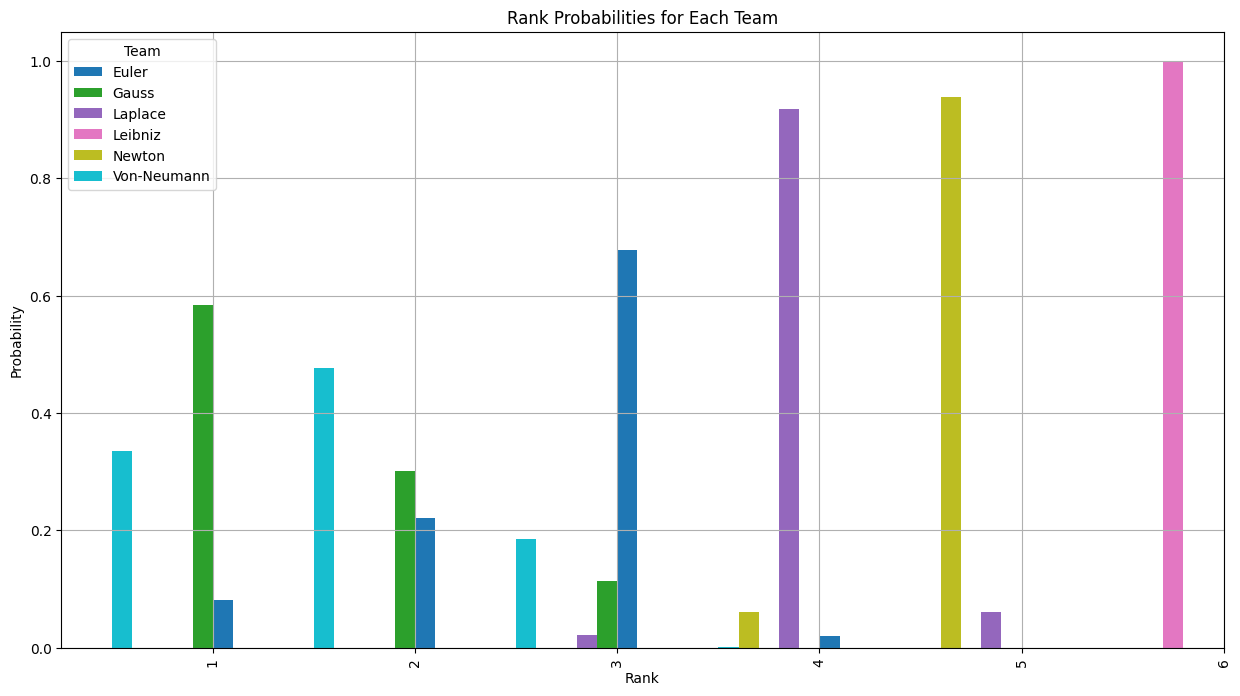

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import numpy as np

RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)

# Sample from the posterior predictive distribution
with mathball:
    ppc = pm.sample_posterior_predictive(trace, extend_inferencedata=True, random_seed=rng)

# Extract and reshape the predicted scores
home_goals = ppc.posterior_predictive["y1"].values.reshape(-1, ppc.posterior_predictive["y1"].shape[-1])
away_goals = ppc.posterior_predictive["y2"].values.reshape(-1, ppc.posterior_predictive["y2"].shape[-1])

# Function to simulate match outcomes and calculate points
def simulate_season(home_goals, away_goals, teams):
    num_games = home_goals.shape[0]
    points = {team: 0 for team in teams}

    for game_idx in range(num_games):
        home_team = teams[home_idx[game_idx]]
        away_team = teams[away_idx[game_idx]]
        home_score = home_goals[game_idx]
        away_score = away_goals[game_idx]

        if home_score > away_score:
            points[home_team] += 3
        elif home_score < away_score:
            points[away_team] += 3
        else:
            points[home_team] += 1
            points[away_team] += 1

    return points

# Simulate the seasons and calculate ranks
num_simulations = home_goals.shape[0]
all_ranks = {team: [] for team in teams}

for i in range(num_simulations):
    points = simulate_season(home_goals[i], away_goals[i], teams)
    sorted_teams = sorted(points.keys(), key=lambda k: points[k], reverse=True)
    for rank, team in enumerate(sorted_teams):
        all_ranks[team].append(rank + 1)

# Convert ranks to a DataFrame
ranks_df = pd.DataFrame({team: pd.Series(ranks) for team, ranks in all_ranks.items()})

# Calculate the probability of each rank for each team
rank_probs = ranks_df.apply(lambda x: x.value_counts(normalize=True)).fillna(0)

# Plot the results
plt.figure(figsize=(15, 8))
width = 0.1  # Width of each bar
colors = plt.cm.get_cmap('tab10', len(teams)).colors  # Different colors for each team

for i, team in enumerate(teams):
    rank_probs[team].sort_index().plot(kind='bar', width=width, position=i, color=colors[i], label=team)

plt.title('Rank Probabilities for Each Team')
plt.xlabel('Rank')
plt.ylabel('Probability')
plt.legend(title='Team')
plt.grid(True)
plt.show()
